# Project 4: West Nile Virus Prediction
Authors: Catherine Ang, Mei Lian, Wenna Loo

## Contents:
- [Introduction](#Introduction)
- [Setup](#Setup)
- [Data Import](#Data-Import)
- [Feature Engineering](#Feature-Engineering)
- [Pre-processing](#Pre-processing)
- [Modelling](#Modelling)
- [Cost Benefit Analysis](#Cost-Benefit-Analysis)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)
- [Limitations and Further Explorations](#Limitations-and-Further-Explorations)

## Introduction

In our earlier notebook, we have performed data cleaning on our **Train**, **Weather** and **Spray** datasets. From our exploratory data analysis, we have noted that:
- Not all species carry WNV - CULEX PIPIENS and CULEX RESTUANS species are the two main carriers of WNV, and they comprise 99.5% of the mosquitos captured in the traps.
- There is an increasing prevalence of WNV during summer - an increasing trend from June, July till it peaks in August, before declining slightly in September. 
- While traps have been placed across Chicago, not all hot-spots (i.e. WNV outbreak locations) have traps set up thoroughly.
- There are only spray information recorded in 2011 and 2013; yet, the spray areas fail to fully overlap with the virus outbreak hot-spots, indicating cause for concern as a result of improper spray coverage.
 
In this notebook,  we'll look into feature engineering, preprocessing steps (eg. feature selection and one-hot encoding) to prepare our data for modeling, modelling, and eventually a cost-benefit analysis.

## Setup
All libraries used should be added here.

In [1]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KernelDensity

sns.set_style('white')
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# path to save the figures
assets_path = '../assets'
os.makedirs(assets_path, exist_ok=True)

# Create a function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(assets_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data Import
Import the datasets required.

In [3]:
# set the input and output relative paths
input_path = '../datasets_cleaned'
output_path = '../datasets_final'
os.makedirs(output_path, exist_ok=True)

In [4]:
# write a function to load the cleaned train data
def load_train_data(filename='train_cleaned.csv'):
    csv_train_path = os.path.join(input_path, filename)
    return pd.read_csv(csv_train_path, parse_dates=['Date'])

# write a function to load the cleaned test data
def load_test_data(filename='test_cleaned.csv'):
    csv_test_path = os.path.join(input_path, filename)
    return pd.read_csv(csv_test_path, parse_dates=['Date'])

# write a function to load the cleaned spray data
def load_spray_data(filename='spray_cleaned.csv'):
    csv_test_path = os.path.join(input_path, filename)
    return pd.read_csv(csv_test_path, parse_dates=['Date'])

# write a function to load the cleaned weather data
def load_weather_data(filename='weather_cleaned.csv'):
    csv_test_path = os.path.join(input_path, filename)
    return pd.read_csv(csv_test_path, parse_dates=['Date'])

In [5]:
train_df = load_train_data()
test_df = load_test_data()
spray_df = load_spray_data()
weather_df = load_weather_data()

In [6]:
# drop address-related columns
train_df = train_df.drop(['Address', 'AddressNumberAndStreet','Block', 'Street', 
                          'AddressAccuracy', 'LatLong', 'Coord'], axis = 1)
test_df = test_df.drop(['Address', 'AddressNumberAndStreet', 'Block', 'Street', 
                        'AddressAccuracy', 'LatLong', 'Coord'], axis = 1)

In [7]:
print('Our train dataset has {} rows and {} columns.'.format(train_df.shape[0], train_df.shape[1]))
print('Our test dataset has {} rows and {} columns.'.format(test_df.shape[0], test_df.shape[1]))
print('Our spray dataset has {} rows and {} columns.'.format(spray_df.shape[0], spray_df.shape[1]))
print('Our weather dataset has {} rows and {} columns.'.format(weather_df.shape[0], weather_df.shape[1]))

Our train dataset has 8475 rows and 12 columns.
Our test dataset has 116293 rows and 11 columns.
Our spray dataset has 14294 rows and 3 columns.
Our weather dataset has 2944 rows and 19 columns.


## Feature Engineering
We will look into creating new features in the **Weather**, **Train** and **Test** datasets.

For **Spray** dataset, we have seen that there were only spray records available in 2011 and 2013, amounting to just 10 days. On the other hand, the information available for the other three datasets range from 2007 to 2014. Therefore, we will not be including the **Spray** dataset in our modelling.

### Creating new features in the Weather dataset

In [8]:
# view the top 5 rows of Weather data
weather_df.head()

,AvgSpeed,CodeSum,Cool,Date,Depart,DewPoint,Heat,PrecipTotal,ResultDir,ResultSpeed,SeaLevel,Station,StnPressure,Sunrise,Sunset,Tavg,Tmax,Tmin,WetBulb
0,9.2,,2,2007-05-01,14,51,0,0.0,27,1.7,29.82,1,29.10,448,1849,67,83,50,56
1,9.6,,3,2007-05-01,15,51,0,0.0,25,2.7,29.82,2,29.18,448,1849,68,84,52,57
2,13.4,BR,0,2007-05-02,-3,42,14,0.0,4,13.0,30.09,1,29.38,447,1850,51,59,42,47
3,13.4,BR HZ,0,2007-05-02,-2,42,13,0.0,2,13.3,30.08,2,29.44,447,1850,52,60,43,47
4,11.9,,0,2007-05-03,2,40,9,0.0,7,11.7,30.12,1,29.39,446,1851,56,66,46,48


#### Feature #1: `SunHours` (Sunrise vs Sunset)

The `Sunrise` and `Sunset` features may not be significant to the prediction of WNV, as their breeding activities are likely to be affected by the conditions of the day. Thus, we will creature a new feature called `SunHours` to capture the duration of the day, or number of hours when the Sun is out.

In [9]:
# change datatypes of Sunrise and Sunset values 
weather_df['Sunrise'] = weather_df['Sunrise'].apply(str)
weather_df['Sunset'] = weather_df['Sunset'].apply(str)

In [10]:
# convert Sunrise and Sunset values to datetime
sunrise_time = []
for val in weather_df['Sunrise']:
    date_val = datetime.datetime.strptime(val, '%H%M')
    sunrise_time.append(date_val.hour + date_val.minute/60)

sunset_time = []
for val in weather_df['Sunset']:
    try:
        date_val = datetime.datetime.strptime(val, '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)
    except:
        date_val = datetime.datetime.strptime(val.replace('60', '59'), '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)

# convert values to hours from midnight
weather_df['Sunrise'] = sunrise_time
weather_df['Sunset'] = sunset_time

In [11]:
# create new column to store sunhours
weather_df['SunHours'] = weather_df['Sunset'] - weather_df['Sunrise']

# drop Sunrise and Sunset columns
weather_df.drop(columns=['Sunrise', 'Sunset'], inplace=True)

#### Feature #2: `CodeSumScore` (derived from CodeSum)

The `CodeSum` feature indicates the weather conditions of the day. The following table showcases the different types of abbreviations and their weather conditions:

|Abbreviation|Weather Condition|
|:----------:|:---------------:|
|+FC|TORNADO/WATERSPOUT|
|FC|FUNNEL CLOUD|
|TS|THUNDERSTORM|
|GR|HAIL|
|RA|RAIN|
|DZ|DRIZZLE|
|SN|SNOW|
|SG|SNOW GRAINS|
|GS|SMALL HAIL &/OR SNOW PELLETS|
|PL|ICE PELLETS|
|IC|ICE CRYSTALS|
|FG+|HEAVY FOG (FG & LE.25 MILES VISIBILITY)|
|FG|FOG|
|BR|MIST|
|UP|UNKNOWN PRECIPITATION|
|HZ|HAZE|
|FU|SMOKE|
|VA|VOLCANIC ASH|
|DU|WIDESPREAD DUST|
|DS|DUSTSTORM|
|PO|SAND/DUST WHIRLS|
|SA|SAND|
|SS|SANDSTORM|
|PY|SPRAY|
|SQ|SQUALL|
|DR|LOW DRIFTING|
|SH|SHOWER|
|FZ|FREEZING|
|MI|SHALLOW|
|PR|PARTIAL|
|BC|PATCHES|
|BL|BLOWING|
|VC|VICINITY (LIGHT or HEAVY "NO SIGN" MODERATE|

As current `CodeSum` feature is less easily interpretable, we will map the weather codes to a new column `CodeSumScore`, where **1** captures all conditions related to wet (i.e. rain), and **0** captures all remaining conditions that do not fall under **1**.

In [12]:
# identify codes that are applicable to wet conditions
code_sums = []
wet_codes = ['TS', 'GR', 'RA', 'DZ', 'SH', 'BR', 'UP']

for code in weather_df['CodeSum']:
    code.replace('+', ' ')
    code_row = code.split()
    check_wet = 0
    for val in code_row:
        val_2 = None
        if len(val) > 2:
            val_1 = val[:2]
            val_2 = val[2:]
        else:
            val_1 = val
        
        if val_1 in wet_codes or val_2 in wet_codes:
            check_wet = 1

    code_sums.append(check_wet)

In [13]:
# create new column to store the applied codes
weather_df['CodeSumScore'] = code_sums

# drop the original CodeSum column
weather_df.drop(columns=['CodeSum'], inplace=True)

#### Feature #3: `Humidity`

We know that high humidity conditions tend to favour mosquito activity, whereas low humidity may inhibit their activity, and even cause mortality (Source: [Orkin, 2021](https://www.orkin.com/other/mosquitoes/activity#:~:text=Warm%20temperatures%20of%20approximately%2080,and%20may%20even%20cause%20mortality.)). Therefore, we will create a new column for `Humidity` using `DewPoint`.

In [14]:
# create a new column for humidity
weather_df['Humidity'] = np.round(100-25/9*(weather_df['Tavg']-weather_df['DewPoint']),1)

# for humidity>100, keep it at 100
weather_df.loc[weather_df['Humidity']>100,'Humidity'] = 100

In [15]:
# drop features not required from weather table
weather_df = weather_df.drop(columns=['Tmax', 'Tmin'])

#### Feature #4: Time-lagged features
From research, we know that the following conditions will affect the mosquitos' ability to survive and breed (Source: [Orkin, 2021](https://www.orkin.com/other/mosquitoes/activity)): 
- Wind
- Temperature
- Humidity
- Precipitation
- Drought & Rainfall

Additionally, the entire life cycle of a mosquito, from an egg to an adult, takes approximately 8-10 days (Source: [CDC, 2021](https://www.cdc.gov/dengue/resources/factsheets/mosquitolifecyclefinal.pdf)). Therefore, we will want to monitor the weather conditions after the past 1, 3, 7 and 14 days.

In [16]:
# split the weather features by stations
weather_df_group1 = weather_df.loc[weather_df['Station']==1]
weather_df_group2 = weather_df.loc[weather_df['Station']==2]

In [17]:
# create a variable to store the weather features to do a time lag on
weat_features = ['AvgSpeed', 'DewPoint', 'PrecipTotal', 'ResultDir', 'ResultSpeed', 'SeaLevel', 'StnPressure',
                'Tavg', 'WetBulb', 'SunHours', 'Humidity']

group1_lag_features = weather_df_group1[weat_features]
group2_lag_features = weather_df_group2[weat_features]

# set the number of lags in days
lags = (1, 3, 7, 14)

# assign new columns to the respective dataframes
group1_weather_lag_features = weather_df_group1.assign(**{f'{col}_lag_{n}': 
                                                          group1_lag_features[col].shift(n) for n in lags 
                                                          for col in group1_lag_features})

group2_weather_lag_features = weather_df_group2.assign(**{f'{col}_lag_{n}': 
                                                          group2_lag_features[col].shift(n) for n in lags 
                                                          for col in group2_lag_features})

In [18]:
# merge both group1_weather_lag_features and group2_weather_lag_features into one dataframe
weather_new_df = pd.concat([group1_weather_lag_features, group2_weather_lag_features])

### Creating new features in the Train and Test datasets

In [19]:
# view the top 5 rows for train data
train_df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month,Week,DayOfWeek,Nearest_Station
0,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,2007,5,22,1,2
1,2007-05-29,CULEX RESTUANS,T048,41.867108,-87.654224,2,0,2007,5,22,1,2
2,2007-05-29,CULEX RESTUANS,T091,41.862292,-87.648860,1,0,2007,5,22,1,2
3,2007-05-29,CULEX RESTUANS,T049,41.896282,-87.655232,1,0,2007,5,22,1,2
4,2007-05-29,CULEX RESTUANS,T153,41.907645,-87.760886,1,0,2007,5,22,1,2


In [20]:
# view the top 5 rows for test data
test_df.head()

,Id,Date,Species,Trap,Latitude,Longitude,Year,Month,Week,DayOfWeek,Nearest_Station
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,24,2,1
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,6,24,2,1
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,6,24,2,1
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,2008,6,24,2,1
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,2008,6,24,2,1


#### Feature #1: `SpeciesType`

We have observed that not all species carry WNV. Since the CULEX PIPIENS and CULEX RESTUANS species are the two main carriers of WNV, and comprising 99.5% of the mosquitos captured in the traps, we will create a new feature `SpeciesType` which maps 'CULEX PIPIENS/RESTUANS' and 'CULEX PIPIENS' to a weightage of 2, 'CULEX RESTUANS' to a weightage of 1, and the remaining species to 0. This will replace the current `Species` feature. 

In [21]:
# create dummy variable for Species
def carrier(df): 
    carrier = []
    for x in df['Species']:
        if x == 'CULEX PIPIENS/RESTUANS':
            carrier.append(2)
        elif x == 'CULEX PIPIENS':
            carrier.append(2)
        elif x == 'CULEX RESTUANS':
            carrier.append(1)
        else:
            carrier.append(0)
    return carrier

In [22]:
# create a column to map the Species based on the presence of WNV
train_df['SpeciesType'] = carrier(train_df)
test_df['SpeciesType'] = carrier(test_df)

## Pre-processing
We will merge both **Train** and **Test** datasets with the **Weather** dataset.

### Merging of Train and Test datasets with Weather dataset

In [23]:
# renamed 'Nearest_Station' to 'Station'
train_df.rename(columns = {'Nearest_Station': 'Station'}, inplace=True)
test_df.rename(columns = {'Nearest_Station': 'Station'}, inplace=True)

In [24]:
# merge both train/test and weather datasets
train_weather_df = pd.merge(train_df, weather_new_df, on=['Date', 'Station'])
test_weather_df = pd.merge(test_df, weather_new_df, on=['Date', 'Station'])

In [25]:
# view the top 5 rows in train_weather_df
train_weather_df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month,Week,DayOfWeek,Station,SpeciesType,AvgSpeed,Cool,Depart,DewPoint,Heat,PrecipTotal,ResultDir,ResultSpeed,SeaLevel,StnPressure,Tavg,WetBulb,SunHours,CodeSumScore,Humidity,AvgSpeed_lag_1,DewPoint_lag_1,PrecipTotal_lag_1,ResultDir_lag_1,ResultSpeed_lag_1,SeaLevel_lag_1,StnPressure_lag_1,Tavg_lag_1,WetBulb_lag_1,SunHours_lag_1,Humidity_lag_1,AvgSpeed_lag_3,DewPoint_lag_3,PrecipTotal_lag_3,ResultDir_lag_3,ResultSpeed_lag_3,SeaLevel_lag_3,StnPressure_lag_3,Tavg_lag_3,WetBulb_lag_3,SunHours_lag_3,Humidity_lag_3,AvgSpeed_lag_7,DewPoint_lag_7,PrecipTotal_lag_7,ResultDir_lag_7,ResultSpeed_lag_7,SeaLevel_lag_7,StnPressure_lag_7,Tavg_lag_7,WetBulb_lag_7,SunHours_lag_7,Humidity_lag_7,AvgSpeed_lag_14,DewPoint_lag_14,PrecipTotal_lag_14,ResultDir_lag_14,ResultSpeed_lag_14,SeaLevel_lag_14,StnPressure_lag_14,Tavg_lag_14,WetBulb_lag_14,SunHours_lag_14,Humidity_lag_14
0,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,2007,5,22,1,2,2,7.4,12,13,59,0,0.0,16,5.8,30.09,29.44,77,66,14.933333,1,50.0,5.2,49.0,0.0,8.0,4.7,30.14,29.49,65.0,57.0,14.916667,55.6,7.8,55.0,0.28,15.0,2.5,30.1,29.42,60.0,57.0,14.883333,86.1,10.6,44.0,0.0,16.0,10.1,30.05,29.41,74.0,58.0,14.766667,16.7,10.8,56.0,0.6,25.0,8.1,29.83,29.19,69.0,61.0,14.533333,63.9
1,2007-05-29,CULEX RESTUANS,T048,41.867108,-87.654224,2,0,2007,5,22,1,2,1,7.4,12,13,59,0,0.0,16,5.8,30.09,29.44,77,66,14.933333,1,50.0,5.2,49.0,0.0,8.0,4.7,30.14,29.49,65.0,57.0,14.916667,55.6,7.8,55.0,0.28,15.0,2.5,30.1,29.42,60.0,57.0,14.883333,86.1,10.6,44.0,0.0,16.0,10.1,30.05,29.41,74.0,58.0,14.766667,16.7,10.8,56.0,0.6,25.0,8.1,29.83,29.19,69.0,61.0,14.533333,63.9
2,2007-05-29,CULEX RESTUANS,T091,41.862292,-87.648860,1,0,2007,5,22,1,2,1,7.4,12,13,59,0,0.0,16,5.8,30.09,29.44,77,66,14.933333,1,50.0,5.2,49.0,0.0,8.0,4.7,30.14,29.49,65.0,57.0,14.916667,55.6,7.8,55.0,0.28,15.0,2.5,30.1,29.42,60.0,57.0,14.883333,86.1,10.6,44.0,0.0,16.0,10.1,30.05,29.41,74.0,58.0,14.766667,16.7,10.8,56.0,0.6,25.0,8.1,29.83,29.19,69.0,61.0,14.533333,63.9
3,2007-05-29,CULEX RESTUANS,T049,41.896282,-87.655232,1,0,2007,5,22,1,2,1,7.4,12,13,59,0,0.0,16,5.8,30.09,29.44,77,66,14.933333,1,50.0,5.2,49.0,0.0,8.0,4.7,30.14,29.49,65.0,57.0,14.916667,55.6,7.8,55.0,0.28,15.0,2.5,30.1,29.42,60.0,57.0,14.883333,86.1,10.6,44.0,0.0,16.0,10.1,30.05,29.41,74.0,58.0,14.766667,16.7,10.8,56.0,0.6,25.0,8.1,29.83,29.19,69.0,61.0,14.533333,63.9
4,2007-05-29,CULEX RESTUANS,T153,41.907645,-87.760886,1,0,2007,5,22,1,2,1,7.4,12,13,59,0,0.0,16,5.8,30.09,29.44,77,66,14.933333,1,50.0,5.2,49.0,0.0,8.0,4.7,30.14,29.49,65.0,57.0,14.916667,55.6,7.8,55.0,0.28,15.0,2.5,30.1,29.42,60.0,57.0,14.883333,86.1,10.6,44.0,0.0,16.0,10.1,30.05,29.41,74.0,58.0,14.766667,16.7,10.8,56.0,0.6,25.0,8.1,29.83,29.19,69.0,61.0,14.533333,63.9


In [26]:
# view the top 5 rows in test_weather_df
test_weather_df.head()

,Id,Date,Species,Trap,Latitude,Longitude,Year,Month,Week,DayOfWeek,Station,SpeciesType,AvgSpeed,Cool,Depart,DewPoint,Heat,PrecipTotal,ResultDir,ResultSpeed,SeaLevel,StnPressure,Tavg,WetBulb,SunHours,CodeSumScore,Humidity,AvgSpeed_lag_1,DewPoint_lag_1,PrecipTotal_lag_1,ResultDir_lag_1,ResultSpeed_lag_1,SeaLevel_lag_1,StnPressure_lag_1,Tavg_lag_1,WetBulb_lag_1,SunHours_lag_1,Humidity_lag_1,AvgSpeed_lag_3,DewPoint_lag_3,PrecipTotal_lag_3,ResultDir_lag_3,ResultSpeed_lag_3,SeaLevel_lag_3,StnPressure_lag_3,Tavg_lag_3,WetBulb_lag_3,SunHours_lag_3,Humidity_lag_3,AvgSpeed_lag_7,DewPoint_lag_7,PrecipTotal_lag_7,ResultDir_lag_7,ResultSpeed_lag_7,SeaLevel_lag_7,StnPressure_lag_7,Tavg_lag_7,WetBulb_lag_7,SunHours_lag_7,Humidity_lag_7,AvgSpeed_lag_14,DewPoint_lag_14,PrecipTotal_lag_14,ResultDir_lag_14,ResultSpeed_lag_14,SeaLevel_lag_14,StnPressure_lag_14,Tavg_lag_14,WetBulb_lag_14,SunHours_lag_14,Humidity_lag_14
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,24,2,1,2,10.0,9,7,56,0,0.0,18,8.9,29.99,29.28,74,64,15.166667,0,50.0,9.6,56.0,0.01,25.0,8.8,29.89,29.18,69.0,61.0,15.166667,63.9,12.2,68.0,1.24,18.0,6.5,29.81,29.11,75.0,70.0,15.133333,80.6,5.2,59.0,0.01,4.0,4.5,29.62,28.9,66.0,61.0,15.066667,80.6,8.7,32.0,0.0,6.0,8.2,30.34,29.6,53.0,43.0,14.916667,41.7
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,6,24,2,1,1,10.0,9,7,56,0,0.0,18,8.9,29.99,29.28,74,64,15.166667,0,50.0,9.6,56.0,0.01,25.0,8.8,29.89,29.18,69.0,61.0,15.166667,63.9,12.2,68.0,1.24,18.0,6.5,29.81,29.11,75.0,70.0,15.133333,80.6,5.2,59.0,0.01,4.0,4.5,29.62,28.9,66.0,61.0,15.066667,80.6,8.7,32.0,0.0,6.0,8.2,30.34,29.6,53.0,43.0,14.916667,41.7
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,6,24,2,1,2,10.0,9,7,56,0,0.0,18,8.9,29.99,29.28,74,64,15.166667,0,50.0,9.6,56.0,0.01,25.0,8.8,29.89,29.18,69.0,61.0,15.166667,63.9,12.2,68.0,1.24,18.0,6.5,29.81,29.11,75.0,70.0,15.133333,80.6,5.2,59.0,0.01,4.0,4.5,29.62,28.9,66.0,61.0,15.066667,80.6,8.7,32.0,0.0,6.0,8.2,30.34,29.6,53.0,43.0,14.916667,41.7
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,2008,6,24,2,1,0,10.0,9,7,56,0,0.0,18,8.9,29.99,29.28,74,64,15.166667,0,50.0,9.6,56.0,0.01,25.0,8.8,29.89,29.18,69.0,61.0,15.166667,63.9,12.2,68.0,1.24,18.0,6.5,29.81,29.11,75.0,70.0,15.133333,80.6,5.2,59.0,0.01,4.0,4.5,29.62,28.9,66.0,61.0,15.066667,80.6,8.7,32.0,0.0,6.0,8.2,30.34,29.6,53.0,43.0,14.916667,41.7
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,2008,6,24,2,1,0,10.0,9,7,56,0,0.0,18,8.9,29.99,29.28,74,64,15.166667,0,50.0,9.6,56.0,0.01,25.0,8.8,29.89,29.18,69.0,61.0,15.166667,63.9,12.2,68.0,1.24,18.0,6.5,29.81,29.11,75.0,70.0,15.133333,80.6,5.2,59.0,0.01,4.0,4.5,29.62,28.9,66.0,61.0,15.066667,80.6,8.7,32.0,0.0,6.0,8.2,30.34,29.6,53.0,43.0,14.916667,41.7


### Applying one-hot encoding to the merged datasets

In [27]:
# apply one-hot encoding in train_weather_df
train_weather_encoded_df = pd.get_dummies(train_weather_df, columns=['Trap', 'SpeciesType', 'CodeSumScore'])

In [28]:
# drop additional columns not required for modelling
train_weather_encoded_df = train_weather_encoded_df.drop(columns=['Date', 'Species', 'Year', 'Month', 'Week', 
                                                                  'DayOfWeek', 'Station'])

In [29]:
# apply one-hot encoding for trap and date values in test data
test_weather_encoded_df = pd.get_dummies(test_weather_df, columns=['Trap', 'SpeciesType', 'CodeSumScore'])

In [30]:
# drop additional columns not required for modelling
test_weather_encoded_df = test_weather_encoded_df.drop(columns=['Date', 'Species', 'Year', 'Month', 'Week', 
                                                                'DayOfWeek', 'Station'])

###### Save the encoded dataframes as csv files

In [31]:
# save cleaned train_weather_encoded data
train_weather_encoded_df.to_csv(output_path + '/train_weather_encoded.csv', index=False)

# save cleaned test_weather_encoded data
test_weather_encoded_df.to_csv(output_path + '/test_weather_encoded.csv', index=False)

### Exploring Polynomial Feature Engineering

In our earlier notebook, we have observed that all our features have very low correlation with our target variable, WnvPresent. There is also presence of multicollinearity, where some of the predictor variables have very high correlation between each other.

As such, we will be exploring polynomial feature engineering, as combining or transforming some of the features can often improve a feature's correlation to the target variable significantly. This also enables us to identify any further relationships between the our variables. 

In [32]:
# obtain X and y variables
X = train_weather_encoded_df[[col for col in train_weather_encoded_df.columns if 'WnvPresent' not in col]]._get_numeric_data()
y = train_weather_encoded_df['WnvPresent']

In [33]:
# drop 'NumMosquitos' from X as 'NumMosquitos' will be highly correlated with weather features
X = X.drop(columns=['NumMosquitos'])

In [34]:
# generate the polynomial features, with degree of 2
poly = PolynomialFeatures(include_bias=False, degree=2)

# transform the features
X_poly = poly.fit_transform(X)

# view the shape
print('Our train data with polynomial features included has {} rows and {} columns.'.format(X_poly.shape[0],
                                                                                            X_poly.shape[1]))

Our train data with polynomial features included has 8475 rows and 20502 columns.


In [35]:
# obtain the features' names
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(X.columns))

# generate list of poly feature correlation with y
X_poly_corrs = X_poly.corrwith(y)

In [36]:
# show features that are most highly correlated (positively) with target
X_poly_corrs_ab = abs(X_poly_corrs)
X_poly_corrs_ab.sort_values(ascending=False).head(20)

DewPoint_lag_1 Humidity_lag_3    0.138181
DewPoint_lag_1 SpeciesType_2     0.135486
WetBulb_lag_1 Humidity_lag_3     0.131146
WetBulb_lag_1 SpeciesType_2      0.128856
DewPoint_lag_1 DewPoint_lag_7    0.128381
DewPoint SpeciesType_2           0.127992
Humidity_lag_3 SpeciesType_2     0.127677
Humidity_lag_1 SpeciesType_2     0.127620
DewPoint_lag_7 SpeciesType_2     0.126985
Cool SpeciesType_2               0.126407
DewPoint_lag_1 WetBulb_lag_7     0.126364
DewPoint_lag_1 Tavg_lag_14       0.125617
Tavg_lag_1 Humidity_lag_3        0.125397
DewPoint_lag_1 WetBulb_lag_14    0.124925
WetBulb SpeciesType_2            0.124240
Tavg_lag_1 SpeciesType_2         0.124032
DewPoint Humidity_lag_3          0.123161
Humidity_lag_7 SpeciesType_2     0.123133
WetBulb_lag_1 DewPoint_lag_7     0.123069
WetBulb_lag_7 SpeciesType_2      0.122421
dtype: float64

Interestingly, most of the top features involve some types of temperature variables. To avoid including too much additional multicollinearity to our model, we choose not to introduce any of these variables into our modelling.

### Applying further checks to ensure that the encoded dataframes tally
As there are features present in the **Train** dataset but not in **Test** dataset, we will run further checks to ensure that both datasets have the same number of columns and are ready for modelling.

In [37]:
print('Our encoded train_weather dataset has {} rows and {} columns.'.format(train_weather_encoded_df.shape[0], 
                                                                             train_weather_encoded_df.shape[1]))
print('Our encoded test_weather dataset has {} rows and {} columns.'.format(test_weather_encoded_df.shape[0], 
                                                                            test_weather_encoded_df.shape[1]))

Our encoded train_weather dataset has 8475 rows and 203 columns.
Our encoded test_weather dataset has 116293 rows and 215 columns.


In [38]:
# align both train and test models based on dummified variables
final_train_df, final_test_df = train_weather_encoded_df.align(test_weather_encoded_df,
                                                               join='left', 
                                                               axis=1)

In [39]:
print('Our final train_weather dataset has {} rows and {} columns.'.format(final_train_df.shape[0], 
                                                                           final_train_df.shape[1]))
print('Our final test_weather dataset has {} rows and {} columns.'.format(final_test_df.shape[0], 
                                                                          final_test_df.shape[1]))

Our final train_weather dataset has 8475 rows and 203 columns.
Our final test_weather dataset has 116293 rows and 203 columns.


In [40]:
# check for null values
print(final_train_df.columns[final_train_df.isnull().any()])
print(final_test_df.columns[final_test_df.isnull().any()])

Index([], dtype='object')
Index(['NumMosquitos', 'WnvPresent'], dtype='object')


In [41]:
# replace null values with 0
final_train_df.replace(np.nan, 0, inplace=True)
final_test_df.replace(np.nan, 0, inplace=True)

In [42]:
# check for null values
print(final_train_df.columns[final_train_df.isnull().any()])
print(final_test_df.columns[final_test_df.isnull().any()])

Index([], dtype='object')
Index([], dtype='object')


### Dropping variables with extremely low correlation to our target variable

With more than 200 columns present in our **Train** and **Test** datasets, we will look to drop some variables with extremely low correlation to our target variable.

In [43]:
# obtain the correlation between features and target variable WnvPresent
cm = abs(final_train_df.corr()['WnvPresent']).sort_values(ascending=False)

# view bottom 10 features with low correlation
cm.tail(10)

Trap_T227             0.001301
Trap_T090             0.001167
Trap_T142             0.000973
Trap_T162             0.000845
Trap_T156             0.000845
Trap_T066             0.000821
StnPressure_lag_14    0.000453
Trap_T135             0.000293
Trap_T226             0.000247
Trap_T033             0.000075
Name: WnvPresent, dtype: float64

Most of the features with extremely low correlation to our target variable `WnvPresent` seem to be the one-hot encoded features such as trap. As such, we will proceed to drop features with less than 2% correlation (absolute) to `WnvPresent`.

In [44]:
# consolidate variables with less than 2% correlation to WnvPresent
cols_to_drop = cm[cm < 0.02].index

In [45]:
# remove columns from final train and test datasets
final_train_df.drop(columns=cols_to_drop, inplace=True)
final_test_df.drop(columns=cols_to_drop, inplace=True)

In [46]:
print('Our final train dataset has {} rows and {} columns.'.format(final_train_df.shape[0], 
                                                                   final_train_df.shape[1]))
print('Our final test dataset has {} rows and {} columns.'.format(final_test_df.shape[0], 
                                                                  final_test_df.shape[1]))

Our final train dataset has 8475 rows and 76 columns.
Our final test dataset has 116293 rows and 76 columns.


###### Save the final dataframes as csv files

In [47]:
# save cleaned final_train data
final_train_df.to_csv(output_path + '/final_train.csv', index=False)

# save cleaned final_test data
final_test_df.to_csv(output_path + '/final_test.csv', index=False)

## Modelling
Before we dive into the prediction of the presence of WNV, we notice that the `NumMosquitos` feature is present in the original **Train** dataset, but missing from the **Test** dataset. Thus, we will first determine the `NumMosquitos` values to be applied in the **Test** dataset, using the final dataframes that we have prepared. 

### Determine the `NumMosquitos` in the Test dataset

<AxesSubplot:title={'center':'Distribution of Number of Mosquitos across Chicago'}, xlabel='NumMosquitos', ylabel='Density'>

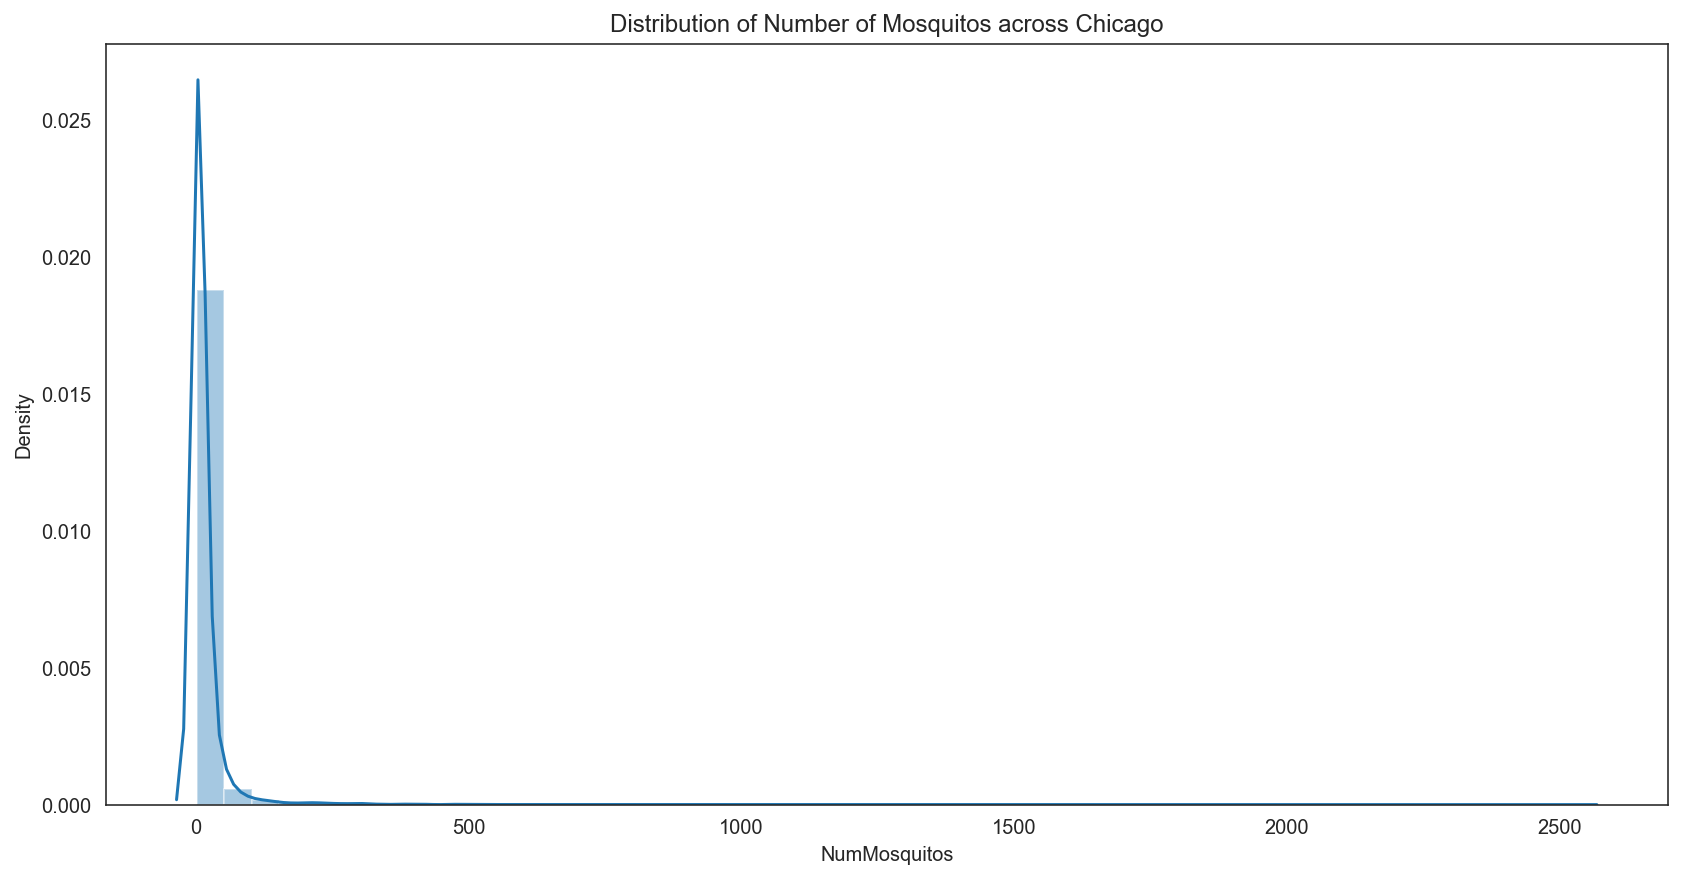

In [48]:
# view the distribution of NumMosquitos in train dataset
plt.figure(figsize=(14,7))
plt.title('Distribution of Number of Mosquitos across Chicago')
sns.distplot(final_train_df['NumMosquitos'], kde=True)

In [49]:
# obtain the skew and kurtosis of the NumMosquitos distribution
print("Skew is:", final_train_df.NumMosquitos.skew())
print("Kurtosis: %f" % final_train_df.NumMosquitos.kurt())

Skew is: 19.493830102589513
Kurtosis: 492.591368


#### Predicting the `NumMosquitos` with Poisson Regression
Since the distribution of the number of mosquitos is strongly right-skewed, we will use Poisson Regression to predict the number of mosquitos in the test dataset (while adjusting for the right skew). 

In [50]:
# assign X and y values
y = final_train_df['NumMosquitos']
X = final_train_df.drop(columns=['NumMosquitos', 'WnvPresent'])

In [51]:
# create train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [52]:
# fit model with Poisson Regression
glm_poi = sm.GLM(y, X, family=sm.families.Poisson(link = sm.families.links.log())).fit()

# print the training summary
print(glm_poi.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           NumMosquitos   No. Observations:                 8475
Model:                            GLM   Df Residuals:                     8403
Model Family:                 Poisson   Df Model:                           71
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3436e+05
Date:                Thu, 29 Jul 2021   Deviance:                   2.3969e+05
Time:                        23:11:15   Pearson chi2:                 4.87e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Latitude              -2.8505      0

In [53]:
# create X values from actual test data
X_from_test = final_test_df.drop(columns=['NumMosquitos', 'WnvPresent'])

# apply predictions on actual test data
pred_num_mosquitos = glm_poi.predict(X_from_test)

In [54]:
# add predictions to the test_weather_df
final_test_df['NumMosquitos'] = pred_num_mosquitos.round()

# view numerical description of no. of mosquitos predicted
final_test_df['NumMosquitos'].describe()

count    116293.000000
mean         12.237512
std          58.473902
min           0.000000
25%           1.000000
50%           2.000000
75%           8.000000
max        5286.000000
Name: NumMosquitos, dtype: float64

### Predict `WnvPresent` using Train dataset
Since we have obtained the `NumMosquitos` values in the **Test** dataset, we will proceed to do the modelling on the **Train** dataset, to determine the presence of WNV. 

In [55]:
# assign X and y values
y = final_train_df['WnvPresent']
X = final_train_df.drop(columns=['WnvPresent'])

In [56]:
# create train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

#### Model Baseline
To evaluate whether our model's predictions are appropriate, we will need to establish a baseline model. The baseline provides a point of comparison for the various modelling approaches that we will be evaluating subsequently. 

In [57]:
# obtain distribution of WnvPresent
y.value_counts(normalize=True)

0    0.946077
1    0.053923
Name: WnvPresent, dtype: float64

We observe that our dataset is heavily imbalanced, where we will be 94.6% accurate if we are able to predict all to be the negative class (i.e. WNV not present). Therefore, we will be optimizing our models using **ROC AUC**, instead of accuracy. Concurrently, we will also be deploying **SMOTE (Synthetic Minority Over-sampling Technique)** to help with the over-sampling.

In [58]:
# set y
y_pred = 0
y_train_baseline = np.array([y_pred] * y_train.shape[0])
y_test_baseline = np.array([y_pred] * y_test.shape[0])

In [59]:
# evaluate metrics - accuracy, roc auc scores
print('---Train Set---')
print('Baseline Train Accuracy Score: {}'.format(accuracy_score(y_train, y_train_baseline)))
print('Baseline Train ROC AUC Score: {}'.format(roc_auc_score(y_train, y_train_baseline)))
print('\n')
print('---Test Set---')
print('Baseline Test Accuracy Score: {}'.format(accuracy_score(y_test, y_test_baseline)))
print('Baseline Test ROC AUC Score: {}'.format(roc_auc_score(y_test, y_test_baseline)))

---Train Set---
Baseline Train Accuracy Score: 0.9460552933243426
Baseline Train ROC AUC Score: 0.5


---Test Set---
Baseline Test Accuracy Score: 0.9461266220998821
Baseline Test ROC AUC Score: 0.5


In [60]:
# apply StandardScaler to the data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [61]:
# apply SMOTE to the data
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_sc, y_train) 

# summarize the class distribution
Counter(y_train_sm)

Counter({0: 5612, 1: 5612})

#### Choice of classification models and metrics 

We will be exploring the following classification models for predicting the presence of WNV:
- Logistic Regression
- K-Neighbors Classifier
- Random Forest Classifier
- Extra Trees Classifier
- AdaBoost Classifier
- Gradient Boosting Classifier


Additionally, we will also obtain the following metrics, in addition to ROC AUC score, for comparison across the various models used: 
- Accuracy score
- Recall score
- Precision score
- F1-score

In [62]:
# initialize an empty list to store all the scores and model names
model_name = []
model_train_acc_scores = []
model_test_acc_scores = []
model_crossval_auc_scores = []
model_train_auc_scores = []
model_test_auc_scores = []
model_recall_scores = []
model_precision_scores = []
model_f1_scores = []

In [63]:
# create a function for the modelling
def modelling(model_long_name, model):
    
    # fit the training data
    model.fit(X_train_sm, y_train_sm)

    # obtain the train and test score
    train_score = model.score(X_train_sm, y_train_sm)
    test_score = model.score(X_test_sc, y_test)
    print('Train Accuracy Score: {}'.format(train_score))
    print('Test Accuracy Score: {}'.format(test_score))
    print('\n')
            
    # obtain the cross validation score        
    crossval_score = cross_val_score(model, X_train_sm, y_train_sm, scoring='roc_auc', cv=5).mean()
    print('Cross Validation ROC AUC score: {}'.format(crossval_score))
    print('\n')
    
    # create predictions
    y_preds_train = model.predict(X_train_sm)
    y_preds_test = model.predict(X_test_sc)
    
    # obtain the confusion matrix values
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, y_preds_test),
                       index=['Actual (no WNV)', 'Actual (has WNV)'], 
                       columns=['Predicted (no WNV)', 'Predicted (has WNV)']))
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds_test).ravel()
    print('\n')
    
    # obtain the various metrics
    train_roc_auc = roc_auc_score(y_train_sm, y_preds_train)
    test_roc_auc = roc_auc_score(y_test, y_preds_test)
    print('ROC (train) score: {}'.format(train_roc_auc))
    print('ROC (test) score: {}'.format(test_roc_auc))
    
    # plot the ROC curve
    plot_roc_curve(model, X_test_sc, y_test)
    
    # add worst case scenario line
    plt.plot([0,1], [0,1],
             label = 'baseline',
             linestyle = '--')
    
    # add a legend
    plt.legend()
    print('\n')
    
    # compute other metrics
    test_recall_score = recall_score(y_test, y_preds_test)
    test_precision_score = precision_score(y_test, y_preds_test)
    test_f1_score = f1_score(y_test, y_preds_test)
    print('Recall score: {}'.format(test_recall_score))
    print('Precision score: {}'.format(test_precision_score))
    print('F1-score: {}'.format(test_f1_score))
                
    # append results to the lists
    model_name.append(model_long_name)
    model_train_acc_scores.append(train_score)
    model_test_acc_scores.append(test_score)
    model_crossval_auc_scores.append(crossval_score)
    model_train_auc_scores.append(train_roc_auc)
    model_test_auc_scores.append(test_roc_auc)
    model_recall_scores.append(test_recall_score)
    model_precision_scores.append(test_precision_score)
    model_f1_scores.append(test_f1_score)

Train Accuracy Score: 0.8367783321454028
Test Accuracy Score: 0.7703499803381832


Cross Validation ROC AUC score: 0.909712180500807


Confusion matrix:
                  Predicted (no WNV)  Predicted (has WNV)
Actual (no WNV)                 1845                  561
Actual (has WNV)                  23                  114


ROC (train) score: 0.8367783321454029
ROC (test) score: 0.7994748530134519


Recall score: 0.8321167883211679
Precision score: 0.1688888888888889
F1-score: 0.28078817733990147


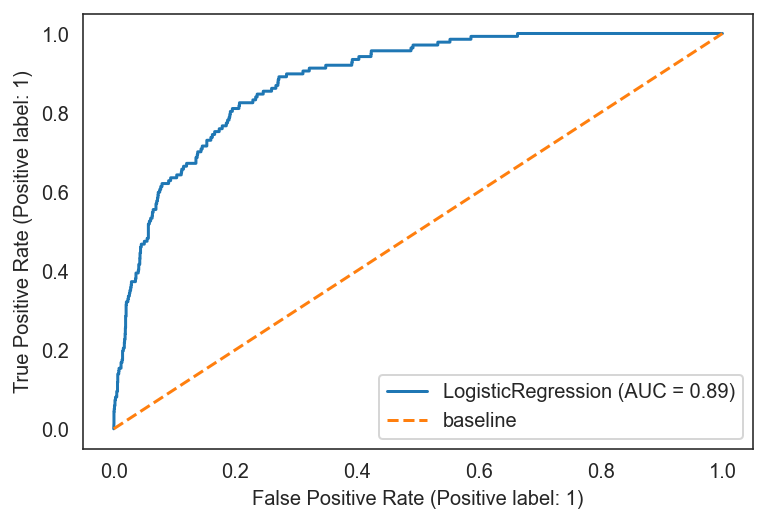

In [64]:
# instantiate model with Logistic Regression and fit it
lr = LogisticRegression()
modelling('Logistic Regression', lr)

Train Accuracy Score: 0.9404846756949394
Test Accuracy Score: 0.8297286669288242


Cross Validation ROC AUC score: 0.9586641226502606


Confusion matrix:
                  Predicted (no WNV)  Predicted (has WNV)
Actual (no WNV)                 2020                  386
Actual (has WNV)                  47                   90


ROC (train) score: 0.9404846756949395
ROC (test) score: 0.7482510269338818


Recall score: 0.656934306569343
Precision score: 0.18907563025210083
F1-score: 0.2936378466557912


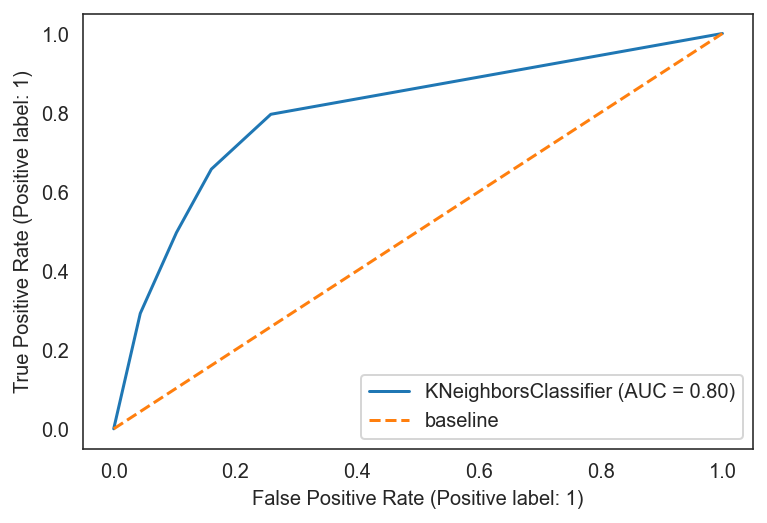

In [65]:
# instantiate model with KNeighborsClassifier and fit it 
knn = KNeighborsClassifier()
modelling('K-Neighbors Classifier', knn)

Train Accuracy Score: 0.9995545260156807
Test Accuracy Score: 0.9217459693275659


Cross Validation ROC AUC score: 0.9879281357466756


Confusion matrix:
                  Predicted (no WNV)  Predicted (has WNV)
Actual (no WNV)                 2279                  127
Actual (has WNV)                  72                   65


ROC (train) score: 0.9995545260156807
ROC (test) score: 0.7108339249200599


Recall score: 0.4744525547445255
Precision score: 0.3385416666666667
F1-score: 0.3951367781155015


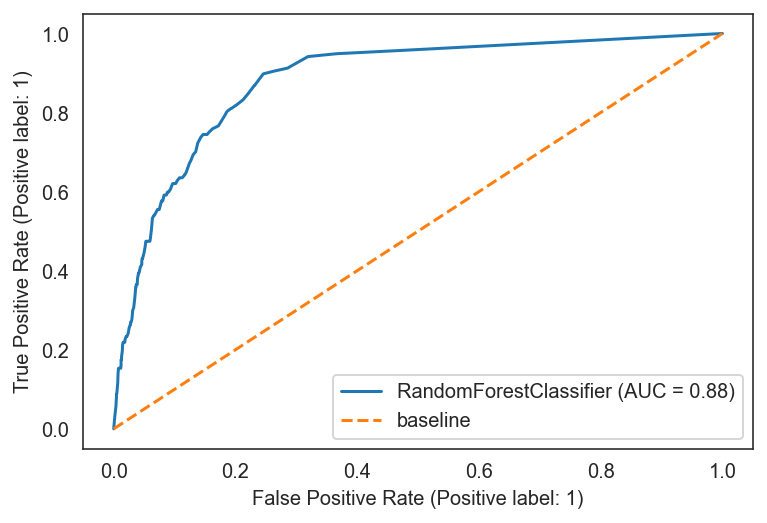

In [66]:
# instantiate model with RandomForestClassifier and fit it 
rf = RandomForestClassifier()
modelling('Random Forest Classifier', rf)

Train Accuracy Score: 0.9995545260156807
Test Accuracy Score: 0.9201730239874164


Cross Validation ROC AUC score: 0.9879271477198042


Confusion matrix:
                  Predicted (no WNV)  Predicted (has WNV)
Actual (no WNV)                 2283                  123
Actual (has WNV)                  80                   57


ROC (train) score: 0.9995545260156806
ROC (test) score: 0.6824680998234343


Recall score: 0.41605839416058393
Precision score: 0.31666666666666665
F1-score: 0.3596214511041009


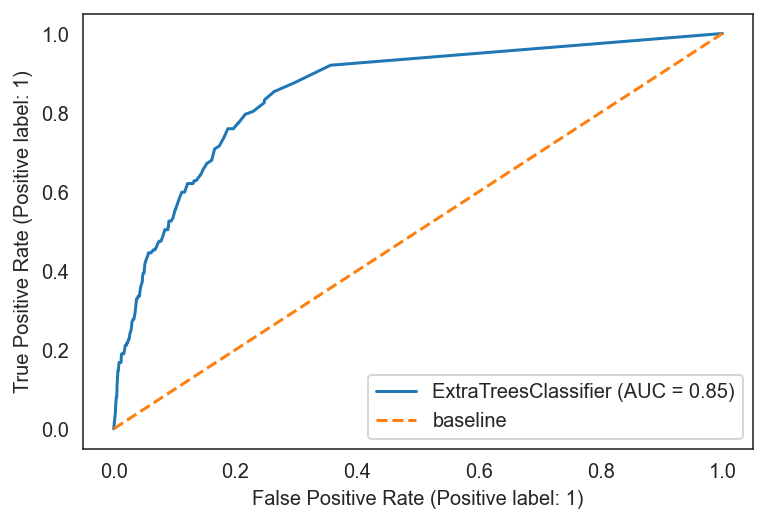

In [67]:
# instantiate model with ExtraTreesClassifier and fit it 
et = ExtraTreesClassifier()
modelling('Extra Trees Classifier', et)

Train Accuracy Score: 0.8957590876692801
Test Accuracy Score: 0.8513566653558788


Cross Validation ROC AUC score: 0.953068574500153


Confusion matrix:
                  Predicted (no WNV)  Predicted (has WNV)
Actual (no WNV)                 2061                  345
Actual (has WNV)                  33                  104


ROC (train) score: 0.8957590876692801
ROC (test) score: 0.8078662831971167


Recall score: 0.7591240875912408
Precision score: 0.23162583518930957
F1-score: 0.35494880546075086


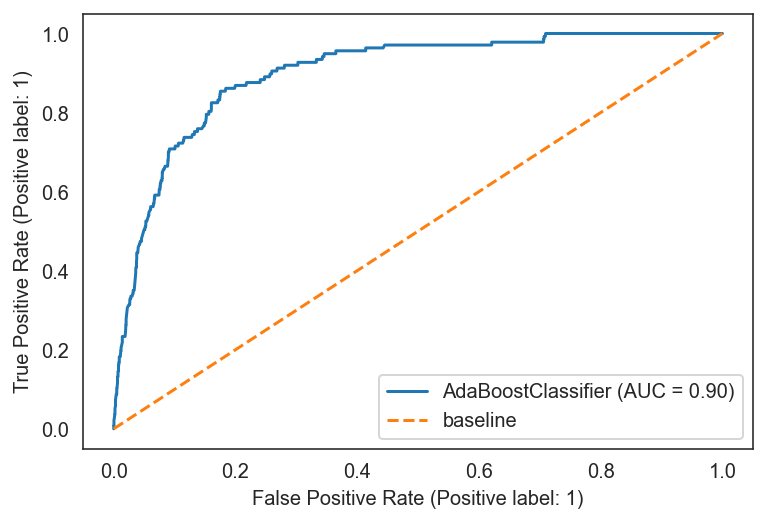

In [68]:
# instantiate model with AdaBoostClassifier and fit it 
ada = AdaBoostClassifier()
modelling('Ada Boost Classifier', ada)

Train Accuracy Score: 0.9249821810406272
Test Accuracy Score: 0.8749508454581203


Cross Validation ROC AUC score: 0.970151459157667


Confusion matrix:
                  Predicted (no WNV)  Predicted (has WNV)
Actual (no WNV)                 2117                  289
Actual (has WNV)                  29                  108


ROC (train) score: 0.9249821810406272
ROC (test) score: 0.8341023960779318


Recall score: 0.7883211678832117
Precision score: 0.27204030226700254
F1-score: 0.40449438202247195


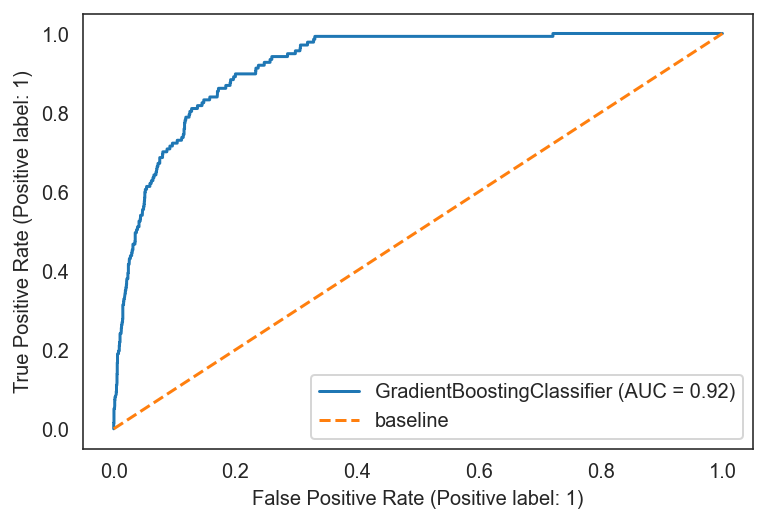

In [69]:
# instantiate model with GradientBoostingClassifier and fit it 
gboost = GradientBoostingClassifier()
modelling('Gradient Boosting Classifier', gboost)

In [70]:
# consolidate all metrics into a DataFrame
model_results = pd.DataFrame({'Model Type': model_name,
                             'Train Accuracy': model_train_acc_scores,
                             'Test Accuracy': model_test_acc_scores,
                             'Cross Val ROC AUC': model_crossval_auc_scores,
                             'Train ROC AUC': model_train_auc_scores,
                             'Test ROC AUC': model_test_auc_scores,
                             'Recall': model_recall_scores,
                             'Precision': model_precision_scores,
                             'F1-Score': model_f1_scores})

In [71]:
# view the model results
model_results

,Model Type,Train Accuracy,Test Accuracy,Cross Val ROC AUC,Train ROC AUC,Test ROC AUC,Recall,Precision,F1-Score
0,Logistic Regression,0.836778,0.770350,0.909712,0.836778,0.799475,0.832117,0.168889,0.280788
1,K-Neighbors Classifier,0.940485,0.829729,0.958664,0.940485,0.748251,0.656934,0.189076,0.293638
2,Random Forest Classifier,0.999555,0.921746,0.987928,0.999555,0.710834,0.474453,0.338542,0.395137
3,Extra Trees Classifier,0.999555,0.920173,0.987927,0.999555,0.682468,0.416058,0.316667,0.359621
4,Ada Boost Classifier,0.895759,0.851357,0.953069,0.895759,0.807866,0.759124,0.231626,0.354949
5,Gradient Boosting Classifier,0.924982,0.874951,0.970151,0.924982,0.834102,0.788321,0.272040,0.404494


### Evaluation of models

Earlier, we have observed that our dataset is heavily imbalanced, where we will be 94.6% accurate if we are able to predict all to be the negative class (i.e. WNV not present). As such, we will not be able to reliably judge the model's performance based on accuracy. Instead, we have decided to optimize the models using **ROC AUC** instead. ROC refers to the receiver operating characteristic curve (i.e. probability curve), whereas AUC indicates the measure of the ability of the model to distinguish between classes. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. In this analysis, the higher the AUC, the better the model is at distinguishing between mosquito traps with WNV present and WNV not present. 

From the scores above, we observe that the Gradient Boosting Classifier has the highest **Test ROC AUC score** of 0.834102. It is close to 1, indicating that the model is good at predicting the classes correctly. Additionally, it has the second highest **Recall score** of 0.788321, which means that the model is capable of predicting entries where WNV is present, and is indeed truly present. The Gradient Boosting Classifier has one of the lowest number of **False Negatives**, which predicts that WNV is not present, when it actually is present. This helps to minimise the amount of information that will be falsely communicated to the public. While the difference between the Train and Test Accuracy remains relatively large, this is considerably acceptable for Gradient Boosting Classifier. 

Therefore, we will select the **Gradient Boosting Classifier** as the production model to be used to predict the presence of WNV. 

**Summary of Gradient Boosting Classifier**

Gradient Boosting Classifier aims to build an ensemble of shallow and weak successive trees, with each tree learning and improving on the previous. 

Some of its advantages include: 
- Flexibility - can optimize on different loss functions and provides several hyperparameter tuning options that make the function fit very flexible;
- No pre-processing of data required - able to work with the original form of categorical and numerical values;
- Handles missing data - imputation is not required.

However, some of its disadvantages include: 
- Overemphasis of outliers which result in overfitting, as the model will continue to improve to minimize errors; 
- Time and computationally extensive, since the model will require a huge number of trees (>1000) - as the data used in this analysis is of a manageable size, it is less computationally intensive; 
- Huge grid search during finetuning, due to the high flexibility of the model that allows the paramters to interact (i.e. number of iterations, depth, etc.) - while the GridSearchCV has taken some time to run, it is applied only after the model selection stage, thus this is still manageable; 
- Less interpretable - this this can be addressed in this analysis by plotting the coefficients of the top features used in the prediction.

### Exploring Gradient Boosting Classifier further
We will identify the best Gradient Boosting Classifier model by applying GridSearchCV to finetune the hyperparameters further. 

In [72]:
# instantiate Gradient Boosting Classifier
gboost = GradientBoostingClassifier()

# list out the parameters
gboost_params = {
    'n_estimators': [80, 100, 120, 150],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# do a gridsearch for the best params for model 
gs_gboost = GridSearchCV(
                gboost,
                gboost_params,
                cv=5,
                scoring='roc_auc',
                verbose=1,
                n_jobs=-1)

# fit the model
gs_gboost.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [80, 100, 120, 150]},
             scoring='roc_auc', verbose=1)

In [73]:
# view the best parameters and scores following the GridSearchCV
print('Best parameters: {}'.format(gs_gboost.best_params_))
print('Best score: {}'.format(gs_gboost.best_score_))

Best parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best score: 0.9751878465576048


In [74]:
# generate predictions
y_preds_test = gs_gboost.best_estimator_.predict(X_test_sc)

# obtain the confusion matrix values
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_preds_test),
                   index=['Actual (no WNV)', 'Actual (has WNV)'], 
                   columns=['Predicted (no WNV)', 'Predicted (has WNV)']))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_test).ravel()

Confusion matrix:
                  Predicted (no WNV)  Predicted (has WNV)
Actual (no WNV)                 2147                  259
Actual (has WNV)                  34                  103


Accuracy Score: 0.8847817538340542
Recall Score: 0.7518248175182481
Precision Score: 0.2845303867403315
F1-Score: 0.4128256513026052
ROC AUC Score: 0.8220886348605373


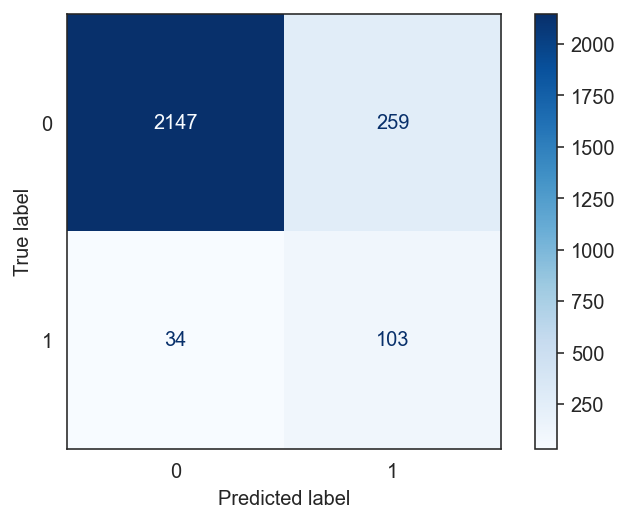

In [75]:
# view the confusion matrix
plot_confusion_matrix(gs_gboost.best_estimator_, X_test_sc, y_test, cmap='Blues', values_format='d');

# print accuracy_score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_preds_test)))
print('Recall Score: {}'.format(recall_score(y_test, y_preds_test)))
print('Precision Score: {}'.format(precision_score(y_test, y_preds_test)))
print('F1-Score: {}'.format(f1_score(y_test, y_preds_test)))
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, y_preds_test)))

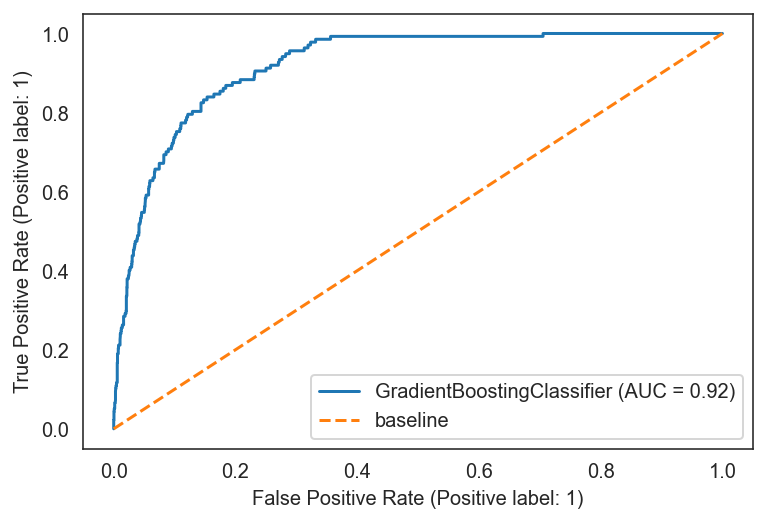

In [76]:
# plot the ROC curve
plot_roc_curve(gs_gboost.best_estimator_, X_test_sc, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1],
         label = 'baseline',
         linestyle = '--')

# add a legend
plt.legend()

By finetuning the hyperparameters further for **Gradient Boosting Classifier**, we observe: 
- An increase in Test Accuracy score, Precision score, F1-score, True Negatives (i.e. traps that are predicted to not have WNV present, and indeed not present); 
- A decrease in Recall score, slight decrease in Test ROC AUC score; 
- A slight increase in False Negatives. 

Since the Test ROC AUC score remains the highest, we will use this best model to predict the presence of WNV in the **Test** dataset.

#### Visualize the top features used for predicting `WnvPresent`

In [77]:
# create a DataFrame containing the features and their coefficients
coefficient_df = pd.DataFrame({'feature':X_test.columns, 'weights':gs_gboost.best_estimator_.feature_importances_})

# sort the values by their coefficients 
coefficient_df.sort_values(by=['weights'], inplace=True, ascending=False)

# view the top 20 features
print('Top 20 Features for Gradient Boosting Classifier')
coefficient_df.head(20)

Top 20 Features for Gradient Boosting Classifier


,feature,weights
2,NumMosquitos,0.560116
20,SunHours_lag_1,0.093362
41,SunHours_lag_7,0.055318
31,SunHours_lag_3,0.045471
15,PrecipTotal_lag_1,0.027232
72,SpeciesType_2,0.023001
12,SunHours,0.017466
30,WetBulb_lag_3,0.016878
19,WetBulb_lag_1,0.013043
1,Longitude,0.012310


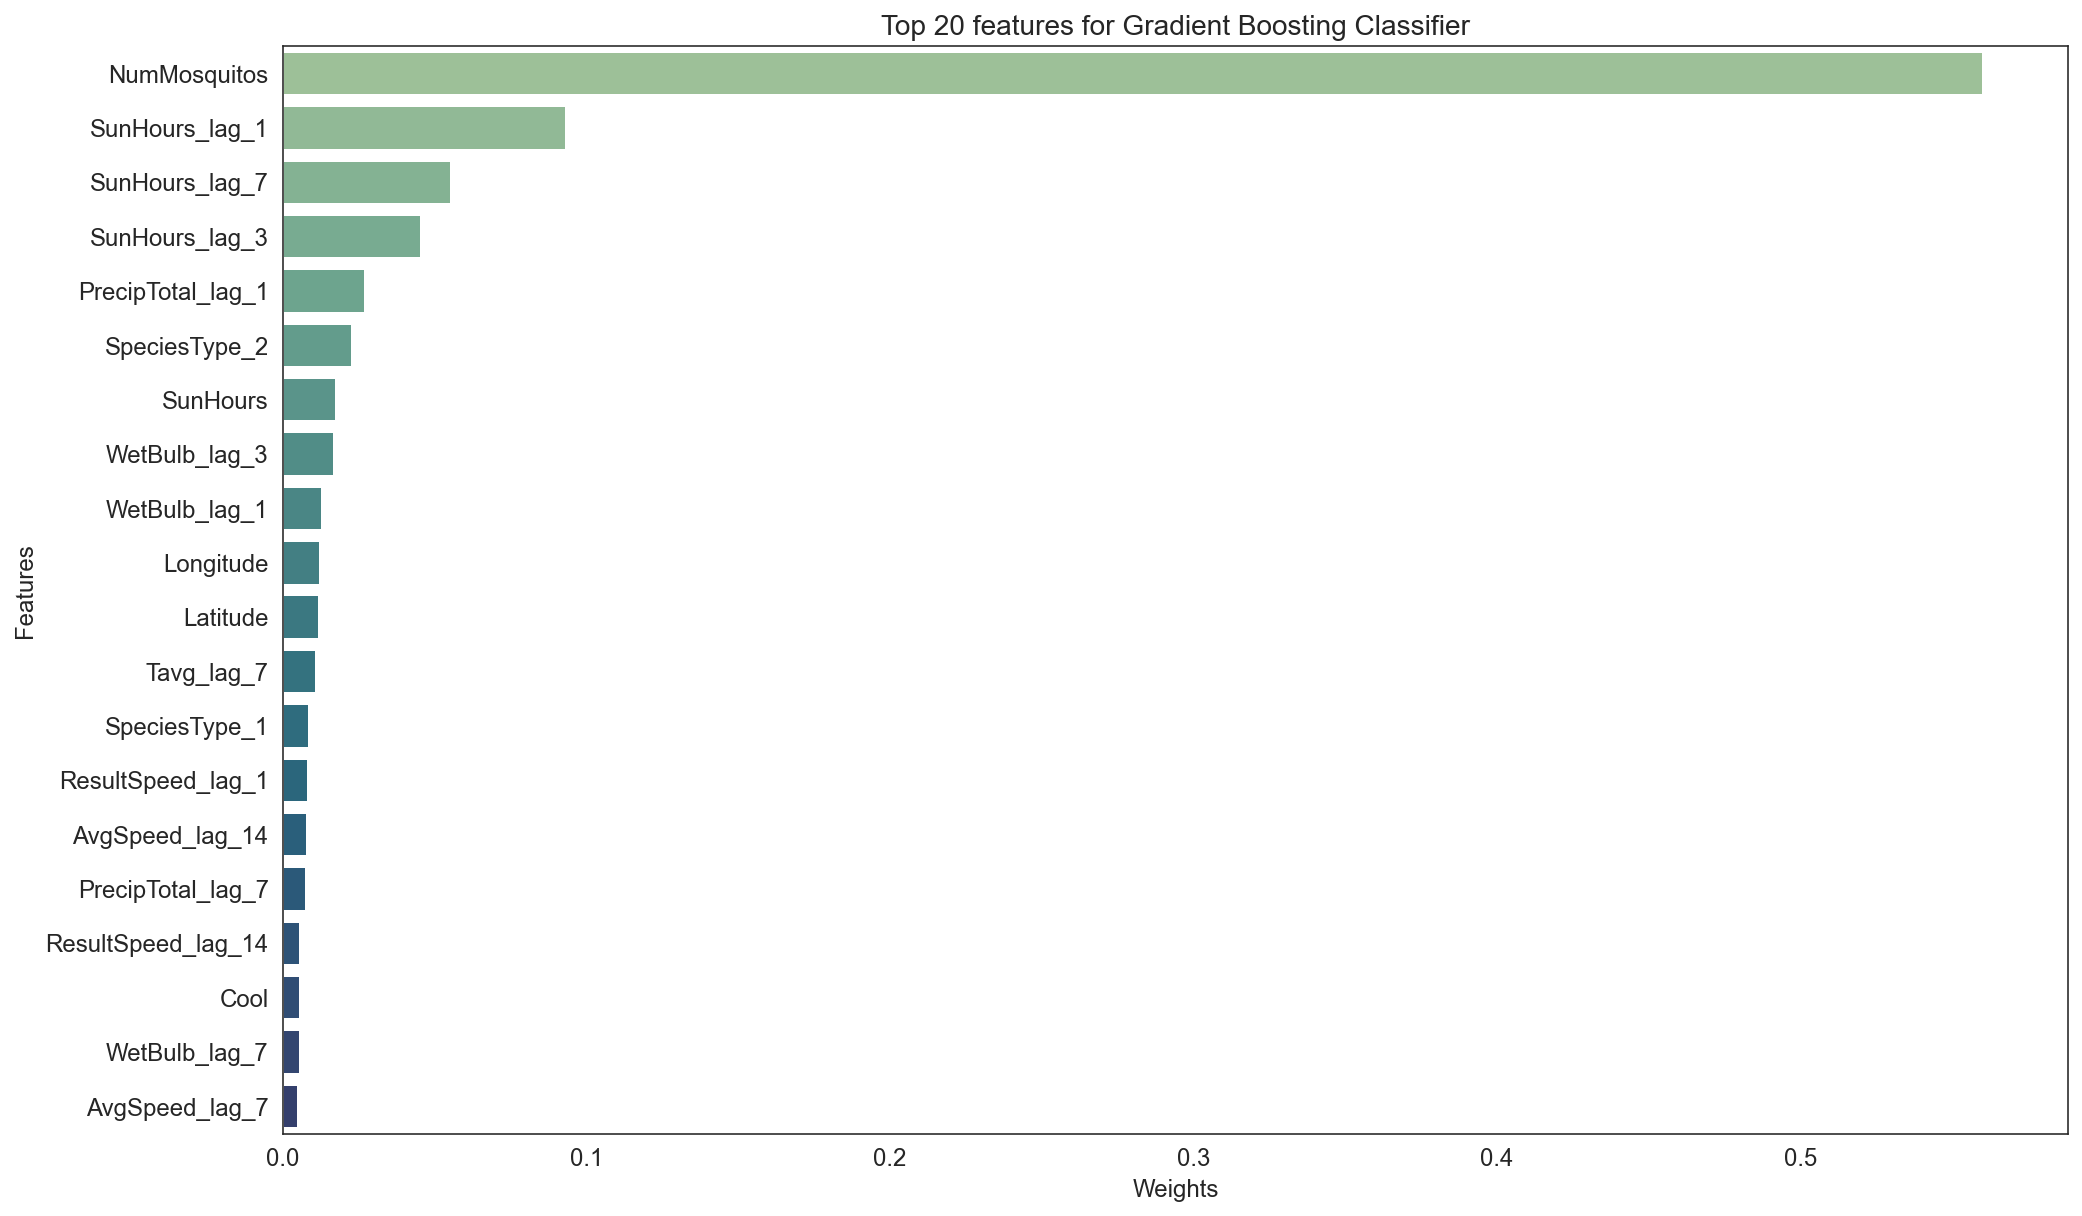

In [78]:
# visualise the top 20 features
plt.figure(figsize=(16,10))
sns.barplot(y='feature', x='weights', data=coefficient_df.head(20), palette='crest')
sns.set(style='whitegrid')
plt.title('Top 20 features for Gradient Boosting Classifier', fontsize=14)
plt.tick_params(labelsize=12)
plt.xlabel('Weights', fontsize=12)
plt.ylabel('Features', fontsize=12);

It is interesting to note that the top factors that may affect the presence of WNV are: Number of Mosquitos, Sun Hours (original and lagged periods), Total Precipitation (lagged periods), Species Type, WetBulb (lagged periods), etc. 
- Number of Mosquitos undoubtedly will contribute to the presence of WNV, as all it takes is for one to be a carrier and to spread it within the trap. 
- The duration of daylight (i.e Sun Hours), total precipitation and wet bulb are crucial, reaffirming the fact that the appropriate weather conditions greatly influence the mosquitos' activities. 
- Species Type plays a major role in the prediction, since only two main mosquito species have displayed presence of WNV during EDA. 

### Generate predictions for `WnvPresent` on Test dataset

In [79]:
# drop the 'Id' and 'Date' columns
X_test_actual = final_test_df.drop(columns=['WnvPresent'])

# scale the dataset
X_test_actual_sc = sc.transform(X_test_actual)

In [80]:
# apply model on actual test data
wnv_present = gs_gboost.best_estimator_.predict(X_test_actual_sc)

# add predictions to the test_df
test_df['WnvPresent'] = wnv_present

# check the proportion of WnvPresent
test_df['WnvPresent'].value_counts()

0    105760
1     10533
Name: WnvPresent, dtype: int64

In [81]:
# prepare file for submission
submission = test_df[['Id', 'WnvPresent']]
submission.set_index('Id', inplace=True)

# save submission file as csv
submission.to_csv(output_path + '/test_submission.csv')

<img src='../assets/kaggle_score_new.jpg' width=950 align=center>

### Combining both Train and Test dataset together

In [82]:
# combine the train and test into one dataframe
combined_df = pd.concat([train_df, test_df])

Saving figure WNV Outbreak Locations (Combined)


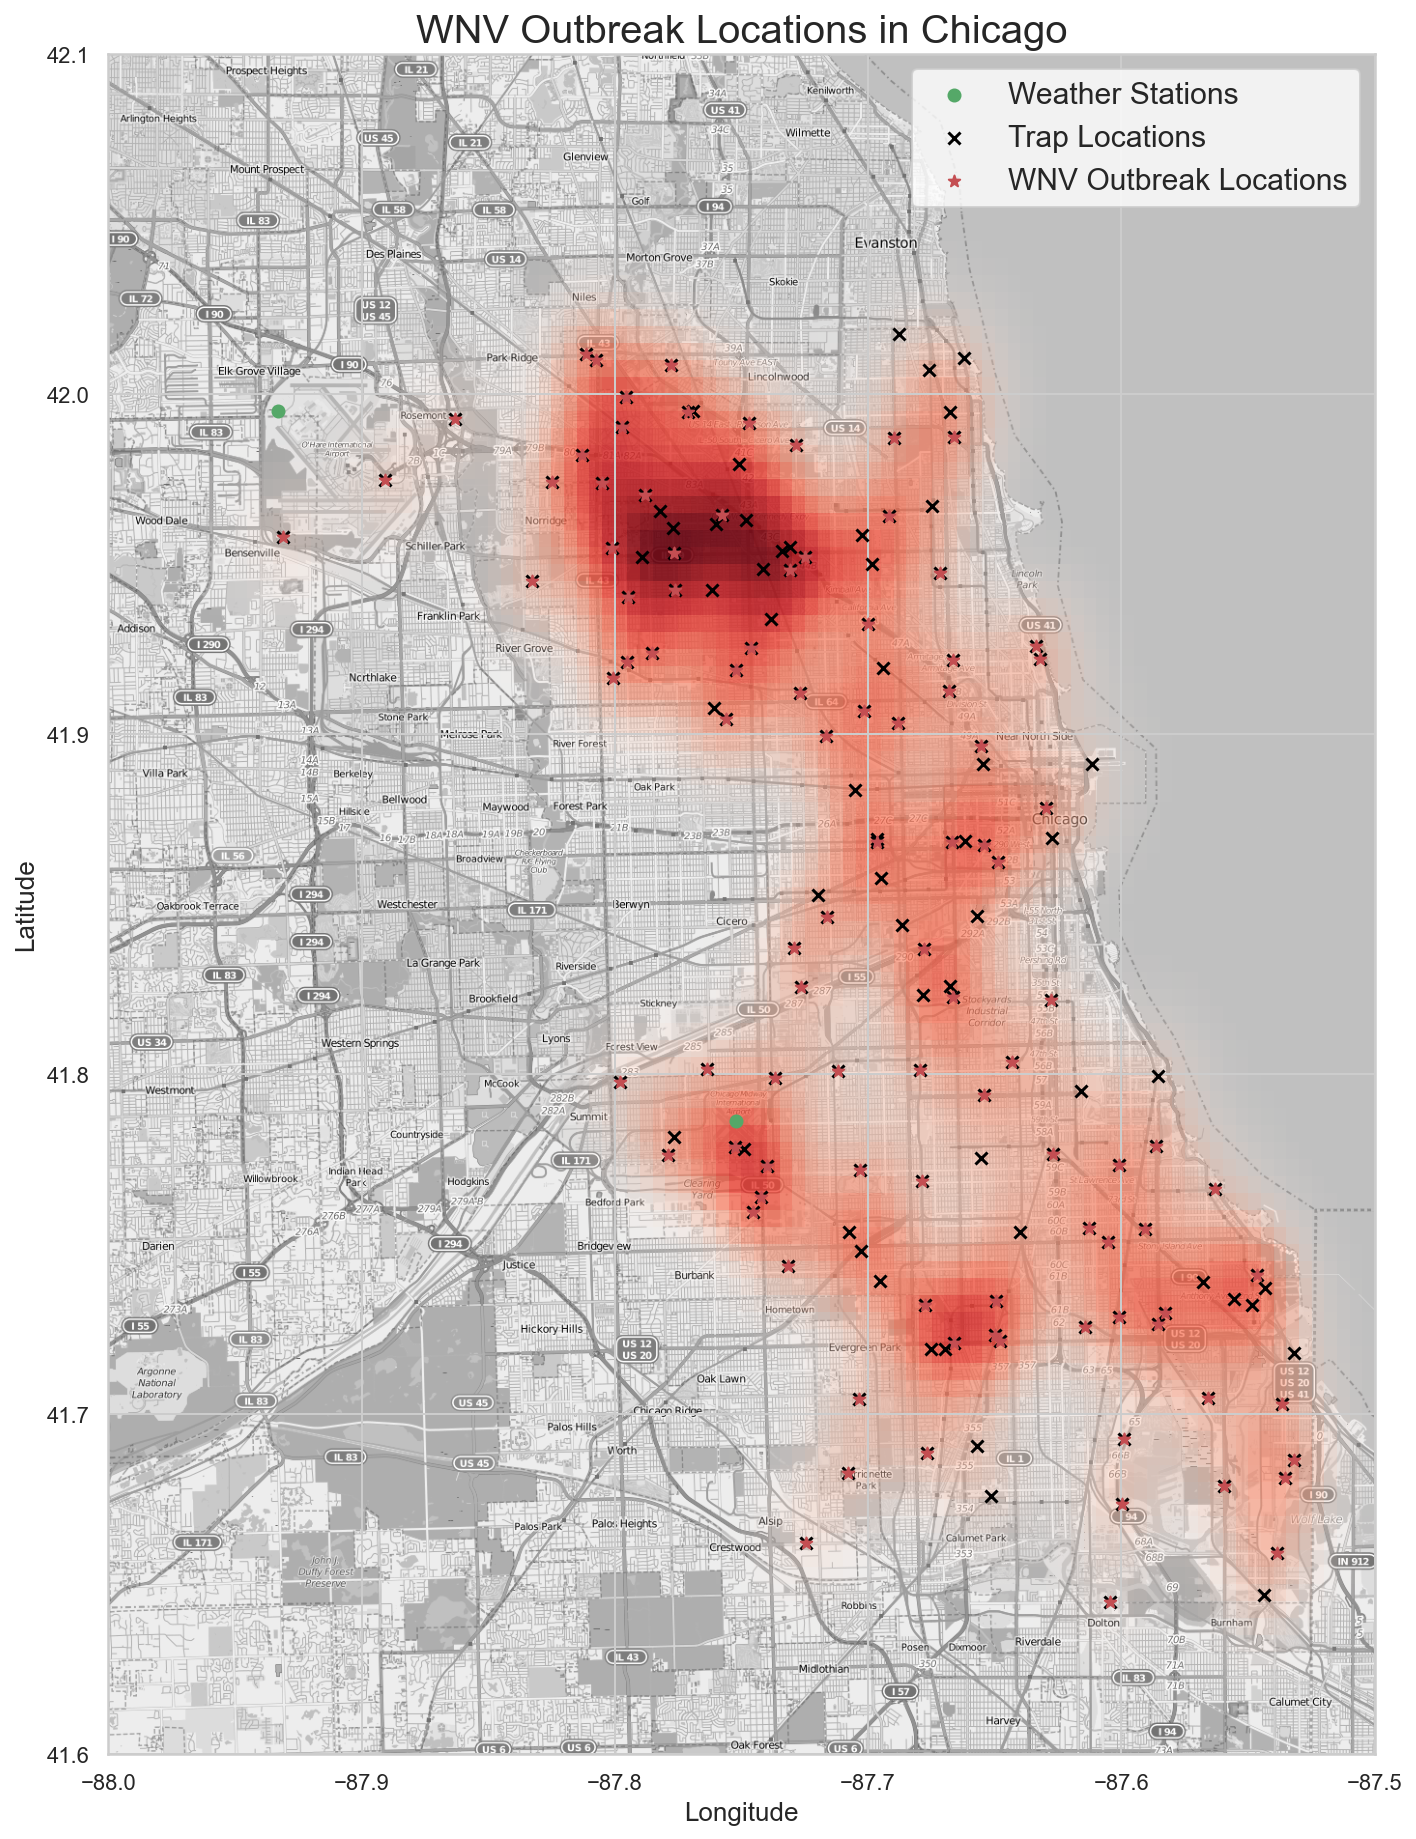

In [83]:
# plot a map of the WNV outbreaks
mapdata = np.loadtxt(input_path + "/mapdata_copyright_openstreetmap_contributors.txt")

alpha_cm1 = plt.cm.Reds
alpha_cm1._init()
alpha_cm1._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm1.N) / 10 - 1)[::-1]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# traps where only WNV is present
wnv = combined_df[combined_df['WnvPresent'] == 1]
wnv = wnv.groupby(['Date', 'Trap','Longitude', 'Latitude'])['WnvPresent'].max().reset_index()
X1 = wnv[['Longitude', 'Latitude']].values
kd1 = KernelDensity(bandwidth=0.015)
kd1.fit(X1)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv1 = np.exp(kd1.score_samples(gridpoints).reshape(100,100))

# kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv1, origin='lower', cmap=alpha_cm1, extent=lon_lat_box, aspect=aspect)

# weather stations
station1 = [-87.933, 41.995]
station2 = [-87.752, 41.786]
station_locations = np.array([station1] + [station2])
plt.scatter(station_locations[:,0], station_locations[:,1], marker='o', c='g', label='Weather Stations')

# trap locations
trap_locations = combined_df[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(trap_locations[:,0], trap_locations[:,1], marker='x', c='black', label='Trap Locations')

# wnv outbreak locations
wnv_locations = train_df[train_df['WnvPresent'] == 1][['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')

plt.title('WNV Outbreak Locations in Chicago', fontsize = 20)
plt.legend(fontsize=15)
plt.xlabel('Longitude', fontsize=13)
plt.ylabel('Latitude', fontsize=13)

save_fig('WNV Outbreak Locations (Combined)')

From the chart above, we can see that the outbreak locations are concentrated around the northern part of Chicago (identified by the darker red regions) and in the southern parts (identified by the lighter red regions). This seems to be consistent over the years, where areas near bodies of water and O'Hare airport have more mosquitos that carry the WNV. These are also the hot-spots which the City of Chicago and CDPH may want to focus on, when allocating sprays to contain the virus outbreak. 

## Cost Benefit Analysis

Every year from June to early October, The Chicago Department of Public Health (CDPH) will conduct citywide mosquito surveillance program to determine the locations to spray adult mosquitoes. <br>

If weather permits, the spraying will begin at dusk and continue through the night until approximately 1:00 am, with licensed mosquito abatement technicians in trucks dispensing an ultra-low-volume spray. [[source]](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes.html)<br>

Licensed technicians in trucks will be spraying an insecticide called Zenivex™ at a rate of 1.5 ounces per acre. [[source]](https://chicago.suntimes.com/2015/8/19/18442891/city-to-spray-mosquito-killing-insecticide-wednesday-night)<br>It is a fast-decomposing, harmless substance commonly used in neighborhoods to control adult mosquitos.<br>

It costs [$0.67 per acre.](https://www.centralmosquitocontrol.com/-/media/files/centralmosquitocontrol-na/us/resources-lit%20files/zenivex%20cost%20comparison%20fact%20sheet.pdf)
<br>

Zenivex™ spray stays in the air for a short time until it lands on surface. [[source]](http://www.ecdpw.org/pdf/pesticide%20info.label.msds/zenivex.pdf)
The active ingredient in Zenivex™ has a half-life of 1.5 days in water and 4.4 days in soil. [[source]](https://www.chicago.gov/content/dam/city/depts/cdph/Mosquito-Borne-Diseases/Zenivex.pdf)


It takes about [8 - 10 days](https://www.cdc.gov/dengue/resources/factsheets/mosquitolifecyclefinal.pdf) for an egg to develop into an adult mosquito. Therefore, it might be recommended to spray every 10 days to minimise occurences of west nile virus.

Assumptions to calculate the cost:
- Spray every 10 days for 4 months: 3 times per month x 4 months = 12 times of spraying
- Chicago area: 149,800 acres

About 1 in 5 people who are infected with the virus will develop a fever with other symptoms such as headache and joint pains, but about one in 150 of those infected develop a serious nervous system illness such as encephalitis or meningitis that typically requires hospitalization.

Using Sacremento County in California' estimated economic impact in 2005 as reference: [[source]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/)

A total of 117 (71.8%) were diagnosed as West Nile fever and 46 (28.2%) as West Nile neuroinvasive disease; 1 (0.6%) case was fatal.
- Medical cost and productivity loss due to West Nile fever: $136,839

- Medical cost and productivity loss due to West Nile neuro-invasive disease: $2,844,338

**Total cost is $2,981,177**

In [84]:
# find out what's the probability of the output that WNV=1
y_pred_prob = gs_gboost.best_estimator_.predict_proba(X_test_sc)[:, 1]

In [85]:
# Medical cost and productivity loss due to West Nile fever: $136,839 for 117 pax
# Medical cost and productivity loss due to West Nile neuro-invasive disease: $2,844,338 for 47 pax

avg_cost_of_treatment_per_person = (136839/117) + (2844338/47)

chicago_acre = 149800
num_of_traps = 136
spray_area_per_trap = chicago_acre/num_of_traps 

cost_per_acre = 0.67 
num_of_spraying = 12 
cost_of_spraying = spray_area_per_trap*num_of_spraying*cost_per_acre

In [86]:
# get the ratio of avg_cost_of_treatment vs cost_of_spraying 
avg_cost_of_treatment_per_person/cost_of_spraying

6.9657433535033

The ratio of **cost of spraying to the average cost of treatment per person** is approximately **1:7**.

In [87]:
# given the ratio above, we will create variable to fit in the function later
spray_cost = 1
medical_cost = 7

In [88]:
# threshold - Since there's imbalanced dataset, we will play around with the threshold
# to determine whether the mosquitoes contain WNV

# tn - True negative, meaning there's no WNV and we didn't take any action
# fp - False Positive, meaning there's no WNV but we thought there is so we spray
# fn - False Negative, meaning there's WNV but we thought there isn't so there's medical cost incurred
# tp - True Positive, meaning there's WNV and the cost/benefit is the difference between spray cost and medical cost

def cost_benefit_analysis(y_test, y_pred_prob, threshold, 
                          cost=dict(tn=0, fp=spray_cost, fn=medical_cost, tp=spray_cost-medical_cost)):
    
    y_pred_class = np.where(y_pred_prob > threshold, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
    
    # return the expected cost
    return (cost['tn']*tn + cost['fp']*fp + cost['fn']*fn + cost['tp']*tp)/(tn+fp+fn+tp)

In [89]:
# find the optimal threshold value and the lowest cost/highest benefit
min_value = 1000   # setting a random value
i_res = 100
for i in range(101):
    value = cost_benefit_analysis(y_test, y_pred_prob, (i)/100, 
                                cost=dict(tn=0, fp=spray_cost, fn=medical_cost, tp=spray_cost-medical_cost))
    
    if min_value > value:
        min_value = value
        i_res = (i)/100
        
print(f'The ideal value for threshold is: {i_res}, and the total cost is: {min_value*116293}')

The ideal value for threshold is: 0.33, and the total cost is: -7362.631930790405


In [90]:
value_1 = cost_benefit_analysis(y_test, y_pred_prob, 0.5, 
                          cost=dict(tn=0, fp=spray_cost, fn=medical_cost, tp=spray_cost-medical_cost))
print(f'For threshold at 0.5, the total cost is: {value_1*116293}')

For threshold at 0.5, the total cost is: -5533.406606370429


In [91]:
value_2 = cost_benefit_analysis(y_test, y_pred_prob, 0.8, 
                          cost=dict(tn=0, fp=spray_cost, fn=medical_cost, tp=spray_cost-medical_cost))
print(f'For threshold at 0.8, the total cost is: {value_2*116293}')

For threshold at 0.8, the total cost is: 9374.77978765238


Based on the different threshold values, we can see that when threshold value is 0.33, the total cost is negative value which means there is expected savings of $7,363.

When threshold value is 0.5, there is expected savings of $5,533.

When threshold value is 0.8, there is expected costs of $9,375.

Therefore, the threshold value of 0.33 is the ideal value to minimise the probability of contracting west nile virus with a good balance of the spray cost while maximising the expected value.

## Conclusion and Recommendations

To recap, we have been tasked to use the mosquito population data collected by the Chicago Department of Public Health (CDPH) to build a model that predicts outbreaks of the West Nile Virus (WNV). Through this analysis, we have not only picked up insights about the mosquito population in Chicago, but also developed a deeper understanding as to how how it is related to the epidemic. Using the data on mosquito traps (train and test datasets), weather and pesticide spraying, we are able to develop several models and evaluate their performances, before selecting the best model and finetuning its hyperparameters further to aid in the determination of the presence of WNV.

We have learnt that features such as the number of mosquitos, duration of the Sun, species type and total precipitation are strong predictors of the presence of WNV. Earlier, our analysis has revealed that not all species carry WNV - CULEX PIPIENS and CULEX RESTUANS species are the two main carriers of WNV, and they comprise 99.5% of the mosquitos captured in the traps. Additionally, we have also observed an increasing prevalence of WNV during summer (beginning from June and peaking in August). This coincides with our external research, which has indicated that mosquitos tend to thrive better in warmer temperatures, with wet/damp conditions and less windy environments (Source: [Orkin, 2021](https://www.orkin.com/other/mosquitoes/activity#:~:text=Warm%20temperatures%20of%20approximately%2080,and%20may%20even%20cause%20mortality.)).

Eventually, we have selected the Gradient Boosting Classifier model, as it has provided us with the highest ROC AUC score of 0.834.  We are confident that our model is capable of predicting outbreaks of West Nile virus. 

From our cost benefit analysis, we would recommend CDPH to ramp up on its spraying efforts, considering a threshold value of 0.33 to minimise the probability of its people contracting WNV while maintaining a balance between the spray cost and maximising the expected benefit. For a start, CDPH can focus on regions in the northern part of Chicago, particularly areas near water bodies.

## Limitations and Further Explorations
While we have employed the SMOTE technique to deal with the imbalanced data - which is capable of mitigating the problem of overfitting caused by random oversampling), one of its downside is that it does not take into consideration neighboring examples from other classes, which may result in an increase in overlapping of classes and thus introducing additional noises. In addition, the dataset is limited to just 2007 to 2014 information, and there are only two years of spraying information. 

Some further explorations include: 
- Employing bagging-based or boosting-based techniques for handling imbalanced data;
- Gathering additional years of pesticides spraying data to examine the effectiveness of the spray;
- Looking into more recent years of trap, weather and spray information (from 2014 onwards);
- Looking at the interaction between temperature and humidity on the growth of mosquitos.